In [1]:
from deep_q_network import DQNAgent
from double_deep_q_network import DoubleDQNAgent

from base_rl_agent_torch import ReplayMemory
from base_neural_model import EstimatorModelBase
from advantage_neural_model import AdvantageModel
import utils
import random
import copy
from Data_binary import *

In [2]:
# Fix seeds for reproducibility.
#utils.fix_seeds(2)

In [3]:
env = Data(unknown_rate=1)
env.loadfile("liver.csv")
env.normalize()
env.alpha = 0
env.cluster_K_means(7)
# this makes it so when we do the ranking, we only check against this number
# of data points
#env.set_validation(2000)
# makes the costs uniform; we won't have groups either
env.set_costs()
# max_cost is the fixed maximum cost the agent can take
env.max_cost = 6/10
# partition into training/test sets
test_env = env.split(0.80)
print("training points:", len(env.data))
print("test points:", len(test_env.data))

training points: 464
test points: 115


In [4]:
MAX_EPISODES = 3000
MAX_STEPS = 32
BATCH_SIZE = 32
buffer = ReplayMemory(100)

# Initiate the agent
model = AdvantageModel
agent = DoubleDQNAgent(env, 
                       model, 
                       buffer,max_steps=MAX_STEPS, 
                       max_episodes=MAX_EPISODES,
                       gamma=0.8,
                       epsilon_decay=0.9992,
                       exploration_penalty=-0.0,
                       verbose=0 # Verbosity level
                      )

In [5]:
#Train
episode_rewards = agent.train(env, MAX_EPISODES, MAX_STEPS, BATCH_SIZE)

We want to plot the reward per episode to examine agent performance.

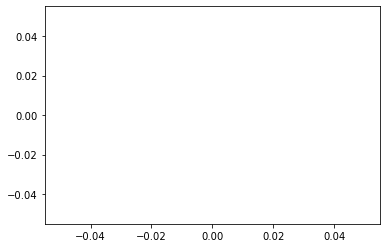

In [6]:
def plot_reward_per_episode(episode_rewards):
    import matplotlib.pyplot as plt
    episode_rewards = episode_rewards[3500:5000]
    x = [i for i in range(len(episode_rewards))]
    plt.plot(x, episode_rewards)
    
plot_reward_per_episode(episode_rewards)

[48.81698161]
[54.67408499]


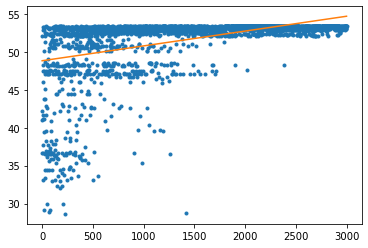

In [7]:
def plot_reward_per_episode(episode_rewards):
    import matplotlib.pyplot as plt
    episode_rewards = episode_rewards[0:15000]
    x = [i for i in range(len(episode_rewards))]
    plt.plot(x, episode_rewards,'.')
    x = np.array(x).reshape(-1,1)
    episode_rewards = np.array(episode_rewards).reshape(-1,1)
    from sklearn import datasets, linear_model
    regr = linear_model.LinearRegression()
    regr.fit(x,episode_rewards)
    y_pred = regr.predict(x)
    plt.plot(x,y_pred,'-')
    print(y_pred[0])
    print(y_pred[-1])
    
plot_reward_per_episode(episode_rewards)

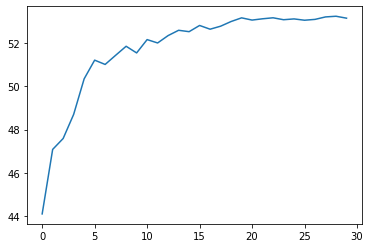

In [8]:
def plot_reward_per_episode(episode_rewards):
    import matplotlib.pyplot as plt
    episode_rewards = episode_rewards[0:]
    x = [i for i in range(len(episode_rewards)//100)]
    avg = [ sum(episode_rewards[i*100:(i+1)*100])/100 for i in range(len(episode_rewards)//100)]
    plt.plot(x, avg)

plot_reward_per_episode(episode_rewards)

In [9]:
test_env.set_validation(1)
for iterations in range(1):
    # Now we evaluate the trained model by taking greedy actions
    total1 = 0
    total2 = 0
    tc1 = 0
    tc2 = 0

    N=len(test_env.data)
    test_env.it = 0
    for it in range(N):
        observation = test_env.next_element() # Current observed state
        ob_cp = (copy.copy(observation[0]),copy.copy(observation[1]), copy.copy(observation[2]))
        #print("ob #:",observation[0])
        total_reward = 0
        agent.epsilon = 0
        i= 0
        done = False
        steps = 0
        cost = 0
        prev = []

        while True:
            if done:
                break;
            action = agent.get_action(observation,env)
            observation, reward, done, info = test_env.step(observation, action)
            total_reward += reward
            steps += 1
        #if (observation[1][-1] > test_env.max_cost):
        #    print("exceeded cost:", observation[1][-1])
        #else:
        #    print("cost1:", observation[1][-1])
        #if (prev != bool_feature(observation[1][:32])):
        #    print("different end state")
        prev = bool_feature(observation[1][:32])
        total1 += (test_env.rank(observation)[0])
        tc1 += observation[1][-1]

        observation = ob_cp
        done = False
        
        s2 = 0
        cost = 0
        while True:
            if done:
                break;
            actions = test_env.actions(observation)
            r = -1
            if (len(actions) != 1):
                r = random.randint(0,len(actions)-2)
            action = actions[r]
            #print("actions:",actions)
            if action != -1 and action < len(observation[1])-1:
                cost += env.costs[action]
            observation, reward, done, info = test_env.step(observation, action)
        total2+=(test_env.rank(observation)[0])
        #print()
        tc2 += observation[1][-1]

    

In [10]:
print("total final score RL:", total1)
print("total final score rand:", total2)
print("total final cost RL:", tc1/N)
print("total final cost rand:", tc2/N)
# Saving the network
#agent.to_pickle("somefile.pickle")

total final score RL: 12.393187704589712
total final score rand: 52.49706644590734
total final cost RL: 0.6000000000000005
total final cost rand: 0.6000000000000005


In [11]:
observation = test_env.next_element()
print("ob:",observation)
done = False
while True:
        if done:
            break;
        action = agent.get_action(observation,env)
        observation, reward, done, info = test_env.step(observation, action)
        total_reward += reward
        steps += 1
        
        prev = bool_feature(observation[1][:32])
        total1 += (test_env.rank(observation)[0])
        tc1 += observation[1][-1]

ob_full = test_env.get(observation[0])

print("ob1:",observation)
print("full:",ob_full)
ranks = test_env.compute_ranks(observation)
print("ranks:",ranks)
print("rank:",test_env.rank(observation))
ret = env.retrieve(ranks, observation[2][:10], 5)
print("ret:",ret)
for r in ret:
    dist = np.linalg.norm(np.array(ob_full[2][:10]) - np.array(r[1]),2)
    print("r:",env.true_ranks[r[0]], dist)
    
d_r = np.linalg.norm( np.array(ob_full[2][:10]) - np.array(env.get(53)[1][:10]), 2)
print("rand:",d_r)
    


ob: (0, [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [-1e-07, -1e-07, -1e-07, -1e-07, -1e-07, -1e-07, -1e-07, -1e-07, -1e-07, -1e-07, -1e-07])
ob1: (0, [0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0.6], [-1e-07, 0.0, 0.00804289544235925, 0.010204081632653062, -1e-07, 0.006030150753768844, 0.003659280341532832, -1e-07, 0.36956521739130443, -1e-07, -1e-07])
full: (0, [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [0.6046511627906976, 0.0, 0.00804289544235925, 0.010204081632653062, 0.06448461162677088, 0.006030150753768844, 0.003659280341532832, 0.4492753623188406, 0.36956521739130443, 0.2, -1e-07])
ranks: [1, 4, 3, 6, 2, 5, 0]
rank: (0.0, True)
ret: [(404, [0.6744186046511628, 0.0, 0.0026809651474530827, 0.0, 0.04738641914997557, 0.016080402010050253, 0.020329335230737954, 0.31884057971014496, 0.36956521739130443, 0.32]), (195, [0.4418604651162791, 0.0, 0.005361930294906167, 0.005102040816326531, 0.03126526624328285, 0.009547738693467337, 0.004065867046147591, 0.31884057971014496, 0.39130434782608703, 0.36]), (369, [0.3953

##### 

In [12]:
def nearest_points(env, p, K):
        dists = [ (np.linalg.norm( np.array(p) - np.array(env.data[i][1]), 2),i) for i in range(len(env.data)) ]
        dists.sort()
        return [ env.data[dists[i][1]] for i in range(K) ]
    
print("full:", ob_full[2])
NN = nearest_points(env,ob_full[1][:10],10)
for n in NN:
    print("n:",n)

full: [0.6046511627906976, 0.0, 0.00804289544235925, 0.010204081632653062, 0.06448461162677088, 0.006030150753768844, 0.003659280341532832, 0.4492753623188406, 0.36956521739130443, 0.2, -1e-07]
n: (315, [0.47674418604651164, 1.0, 0.30697050938337805, 0.6479591836734695, 0.726428920371275, 0.20854271356783918, 0.10184996950599716, 0.7246376811594204, 0.5652173913043479, 0.2])
n: (174, [0.7209302325581395, 0.0, 0.14611260053619304, 0.2806122448979592, 0.5114802149487054, 0.6231155778894473, 1.0, 0.6231884057971014, 0.32608695652173914, 0.08])
n: (91, [0.5813953488372093, 1.0, 0.3056300268096515, 0.6377551020408164, 0.24963361016121152, 0.016582914572864323, 0.007521854035373044, 0.6521739130434783, 0.5652173913043479, 0.24000000000000005])
n: (255, [0.5813953488372093, 1.0, 0.2975871313672923, 0.5765306122448981, 0.2418172936003908, 0.010050251256281407, 0.005488920512299248, 0.7391304347826086, 0.5434782608695653, 0.2])
n: (391, [0.32558139534883723, 0.0, 0.1648793565683646, 0.311224489